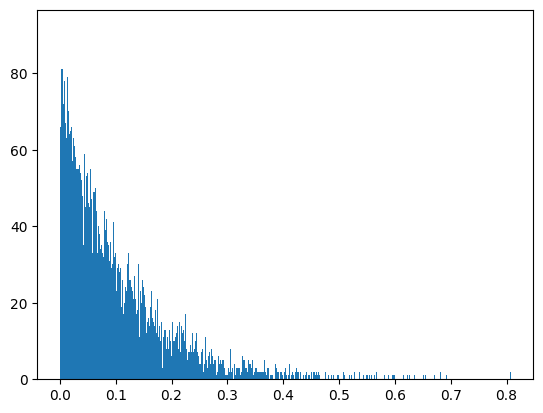

In [2]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import tqdm
from numba import njit

lambd = 10
tau = 1

@njit
def inversion(u, lambd ,tau):
    return -(1/lambd)*np.log(1-u*(1-np.exp(-lambd*tau)))

sample_list = [rd.random() for i in range(10000)]
inv_list = [inversion(u, lambd, tau) for u in sample_list]
plt.hist(inv_list, bins = 1000)
plt.show()

In [5]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt


def get_liquidity_risk(tau, omega, psi, sigma, n_simulations = 100):
    """
    This function simulates the liquidity risk n_simulations times for every timestep tau
    and average the results.
    """
    liquidity_risk_samples = []
    K = int(omega*tau)
    if K==0:
        return 100
    for _ in range(n_simulations):
        sample_list = [rd.random() for i in range(K)]
        arrival_times = [0] + sorted([inversion(u, lambd, tau) for u in sample_list])
        unobservable_price = np.cumsum([np.random.normal(0, np.sqrt(3/2)*psi*np.sqrt(arrival_times[i+1] - arrival_times[i])) for i in range(K)])
        reservation_prices = unobservable_price + np.random.normal(0, sigma, K)
        clearing_price = np.mean(reservation_prices)
        liquidity_risk_sample = clearing_price*np.ones(K) - unobservable_price
        liquidity_risk_samples.append(liquidity_risk_sample)
    liquidity_risk_list = list(map(np.var, np.transpose(liquidity_risk_samples).tolist()))
    return np.mean(liquidity_risk_list)

# PARAMETERS

omega = 300
psi = 0.01
sigma = 0.005
lambd = 10

tau_vals = np.linspace(0.0,50,100)
liquidity_risks = []
for tau in tqdm.tqdm(tau_vals):
    liquidity_risk_tau = get_liquidity_risk(tau, omega, psi, sigma)
    liquidity_risks.append(liquidity_risk_tau)

100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


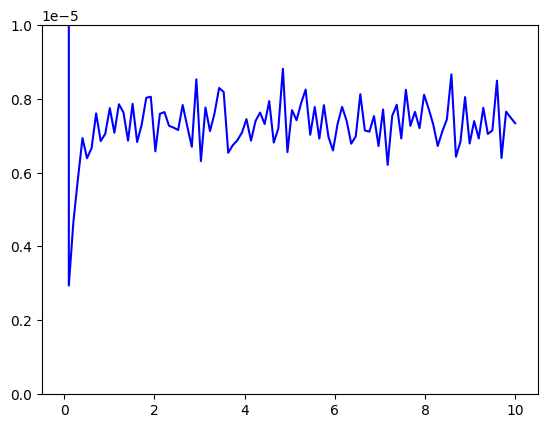

In [4]:
plt.plot(tau_vals[:len(liquidity_risks)], liquidity_risks, c = 'b')
plt.ylim([0,0.00001])
plt.show()

In [18]:
import mpmath
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def liq_risk(tau, sigma,omega, psi, lambd):
    return sigma**2*(1 - np.exp(-omega*tau))/(omega*tau) + psi**2*((np.sinh(lambd*tau) - lambd*tau)*mpmath.csch(lambd*tau/2)**2)/(4*lambd)*(1 - (1 - np.exp(-omega*tau))/(omega*tau))


omega = 30
psi = 0.01
sigma = 0.005

lambd_list = np.linspace(1,10,100)
tau_vals = np.linspace(0.0001,100,10000)
liq_risk_lambd = []

for lambd in tqdm.tqdm(lambd_list):
    liquidity_risks = []
    for tau in tau_vals:
        liquidity_risk_tau = liq_risk(tau, sigma, omega, psi, lambd)
        liquidity_risks.append(liquidity_risk_tau)
    liq_risk_lambd.append(liquidity_risks)

 68%|██████▊   | 68/100 [00:44<00:21,  1.49it/s]C:\Users\Vincelot\AppData\Local\Temp\ipykernel_12204\4247289751.py:7: RuntimeWarning: overflow encountered in sinh
  return sigma**2*(1 - np.exp(-omega*tau))/(omega*tau) + psi**2*((np.sinh(lambd*tau) - lambd*tau)*mpmath.csch(lambd*tau/2)**2)/(4*lambd)*(1 - (1 - np.exp(-omega*tau))/(omega*tau))
100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Text(0, 0.5, 'Liquidity Risk $\\mathbf{L}(\\tau)$')

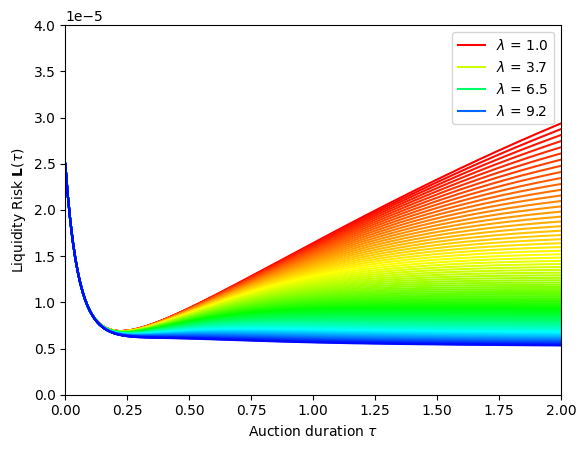

In [35]:
from colour import Color
blue = Color('blue')
red = Color('red')
list_colors = list(red.range_to(blue, 101))

for i, liq_risk in enumerate(liq_risk_lambd):
    if i%30 == 0:
        plt.plot(tau_vals, liq_risk, color = list_colors[i].hex, label = fr"$\lambda$ = {np.round(lambd_list[i],1)}")
    else:
        plt.plot(tau_vals, liq_risk, color = list_colors[i].hex)

plt.legend(loc = 'best')
plt.xlim([0,2])
plt.ylim([0, 4e-5])
plt.xlabel(r'Auction duration $\tau$')
plt.ylabel(r'Liquidity Risk $\mathbf{L}(\tau)$')
